In [ ]:
!pip install mne seaborn -q

import os
import numpy as np
import random

import mne
import matplotlib.pyplot as plt
import seaborn as sns

from glob import glob
from scipy.signal import welch

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from google.colab import drive
drive.mount('/content/drive')


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 33.2 MB/s eta 0:00:00
Mounted at /content/drive


In [ ]:
# Reproducibility
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

# Path where S001R01.edf, S001R02.edf, ... live
DATA_DIR = "/content/drive/MyDrive/eeg_eyes_project"

print(f"Files in {DATA_DIR} (first 10):")
print(os.listdir(DATA_DIR)[:10])

# Window length in seconds (use 2s for smoother features)
WINDOW_SEC = 2.0


Files in /content/drive/MyDrive/eeg_eyes_project (first 10):
['S001R01.edf', 'S001R02.edf', 'S002R01.edf', 'S002R02.edf', 'S003R01.edf', 'S003R02.edf', 'S004R01.edf', 'S004R02.edf', 'S005R01.edf', 'S005R02.edf']


In [ ]:
def bandpower(signal, sf, band):
    """
    Compute log band power in 'band' using Welch PSD.
    band: (fmin, fmax)
    """
    fmin, fmax = band
    freqs, psd = welch(signal, sf, nperseg=256)
    idx = (freqs >= fmin) & (freqs <= fmax)
    return np.log(np.trapz(psd[idx], freqs[idx]) + 1e-12)


def multiband_features(windows, sfreq):
    """
    windows: (n_win, n_chan, n_samples)
    returns: (n_win, n_chan * n_bands)
    """
    bands = {
        "delta": (1, 4),
        "theta": (4, 8),
        "alpha": (8, 13),
        "beta":  (13, 30)
    }

    n_win, n_chan, n_samples = windows.shape
    n_bands = len(bands)
    X = np.zeros((n_win, n_chan * n_bands), dtype=float)

    for i in range(n_win):
        feats = []
        for ch in range(n_chan):
            sig = windows[i, ch, :]
            for b in bands.values():
                feats.append(bandpower(sig, sfreq, b))
        X[i] = feats

    return X


In [ ]:
def extract_features_from_file_optimized(file_path, label, window_sec=WINDOW_SEC):
    """
    file_path : path to EDF
    label     : 0 (open) or 1 (closed)
    returns   : X_feats (n_win, n_feat), y_feats (n_win,)
    """

    raw = mne.io.read_raw_edf(file_path, preload=True, verbose=False)

    raw.pick_types(eeg=True)

    raw.set_eeg_reference('average', projection=False, verbose=False)

    raw.filter(1., 40., fir_design='firwin', verbose=False)

    data = raw.get_data()          # (n_chan, n_samples)
    sfreq = raw.info["sfreq"]

    n_samples_per_win = int(window_sec * sfreq)
    n_total_samples = data.shape[1]
    n_windows = n_total_samples // n_samples_per_win

    if n_windows == 0:
        return None, None

    data = data[:, :n_windows * n_samples_per_win]

    data = data.reshape(
        data.shape[0],
        n_windows,
        n_samples_per_win
    )
    windows = np.transpose(data, (1, 0, 2))

    X_feats = multiband_features(windows, sfreq)

    y_feats = np.full(X_feats.shape[0], label, dtype=int)

    return X_feats, y_feats


In [ ]:
def build_dataset_optimized(data_dir, window_sec=WINDOW_SEC):
    X_list = []
    y_list = []

    files = sorted(glob(os.path.join(data_dir, "*.edf")))
    print("Found", len(files), "EDF files in folder")

    for fpath in files:
        fname = os.path.basename(fpath)

        if "R01" in fname:
            label = 0
        elif "R02" in fname:
            label = 1
        else:
            continue

        print("Processing", fname, "label =", label)

        X_feats, y_feats = extract_features_from_file_optimized(
            fpath, label, window_sec
        )

        if X_feats is None:
            print("  -> Skipping (too short)")
            continue

        X_list.append(X_feats)
        y_list.append(y_feats)

    if len(X_list) == 0:
        raise RuntimeError("No features extracted – check data_dir and filenames.")

    X = np.vstack(X_list)
    y = np.concatenate(y_list)

    print("Final X shape:", X.shape)
    print("Final y shape:", y.shape)
    print("Class counts [open, closed]:", np.bincount(y))

    return X, y

# --- Build dataset ---
X, y = build_dataset_optimized(DATA_DIR, window_sec=WINDOW_SEC)


Found 100 EDF files in folder
Processing S001R01.edf label = 0
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1822160377.py:9: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.log(np.trapz(psd[idx], freqs[idx]) + 1e-12)


Processing S001R02.edf label = 1
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Processing S002R01.edf label = 0
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Processing S002R02.edf label = 1
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Processing S003R01.edf label = 0
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Processing S003R02.edf label = 1
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Processing S004R01.edf label = 0
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Processing S004R02.edf label = 1
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Processing S005R01.edf label = 0
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Processing S005R02.edf label = 1
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Processing

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.25,
    random_state=SEED,
    stratify=y
)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)
print("Train class counts:", np.bincount(y_train))
print("Test class counts:", np.bincount(y_test))

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Train shape: (2250, 256) Test shape: (750, 256)
Train class counts: [1125 1125]
Test class counts: [375 375]


In [ ]:
param_grid = {
    "n_neighbors": [3, 5, 7, 9, 11],
    "weights": ["uniform", "distance"],
    "p": [1, 2]   # 1 = Manhattan, 2 = Euclidean
}

base_knn = KNeighborsClassifier(metric="minkowski")

grid = GridSearchCV(
    base_knn,
    param_grid,
    cv=3,
    scoring="accuracy",
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train_scaled, y_train)

print("Best params:", grid.best_params_)
print("Best CV accuracy:", grid.best_score_)


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best params: {'n_neighbors': 3, 'p': 2, 'weights': 'uniform'}
Best CV accuracy: 0.8697777777777778


In [ ]:
best_knn = grid.best_estimator_

y_pred = best_knn.predict(X_test_scaled)

print("Test accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification report:\n", classification_report(y_test, y_pred))


Test accuracy: 0.8746666666666667

Classification report:
               precision    recall  f1-score   support

           0       0.87      0.88      0.88       375
           1       0.88      0.87      0.87       375

    accuracy                           0.87       750
   macro avg       0.87      0.87      0.87       750
weighted avg       0.87      0.87      0.87       750



                  Pred: Open (0)  Pred: Closed (1)
True: Open (0)               330                45
True: Closed (1)              49               326


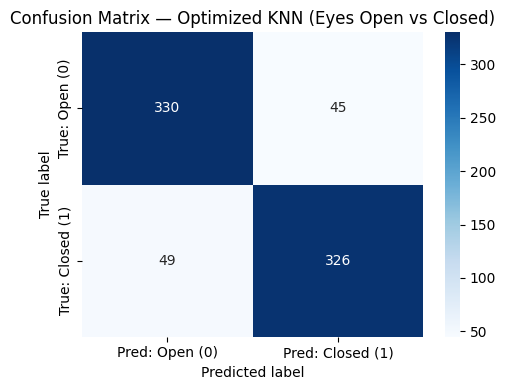

In [ ]:
cm = confusion_matrix(y_test, y_pred)

import pandas as pd
cm_df = pd.DataFrame(
    cm,
    index=["True: Open (0)", "True: Closed (1)"],
    columns=["Pred: Open (0)", "Pred: Closed (1)"]
)

print(cm_df)

plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix — Optimized KNN (Eyes Open vs Closed)")
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.tight_layout()
plt.show()


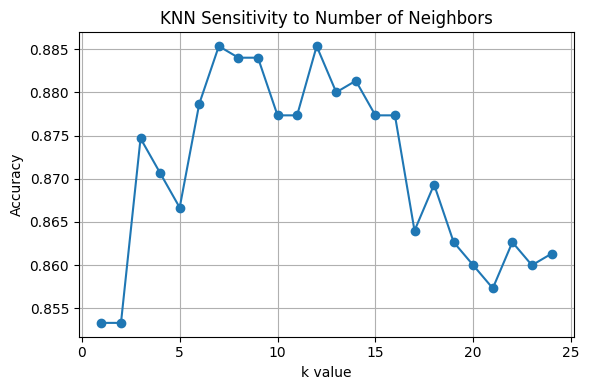

In [ ]:
# accuracy vs K curve
accuracies = []
k_values = range(1, 25)

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    accuracies.append(knn.score(X_test_scaled, y_test))

plt.figure(figsize=(6,4))
plt.plot(k_values, accuracies, marker='o')
plt.xlabel("k value")
plt.ylabel("Accuracy")
plt.title("KNN Sensitivity to Number of Neighbors")
plt.grid(True)
plt.tight_layout()
plt.show()


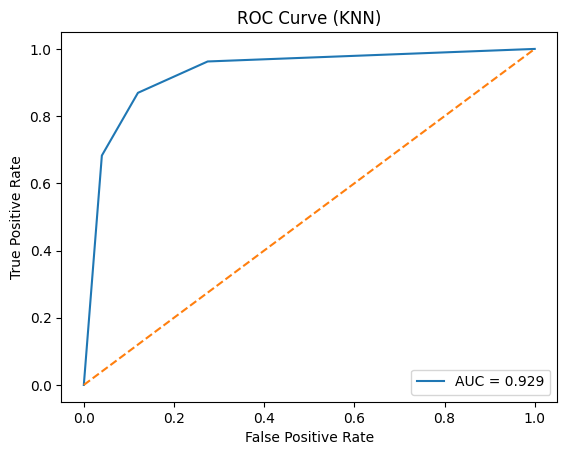

In [ ]:
from sklearn.metrics import roc_curve, auc

y_proba = best_knn.predict_proba(X_test_scaled)[:, 1]

fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (KNN)")
plt.legend()
plt.show()


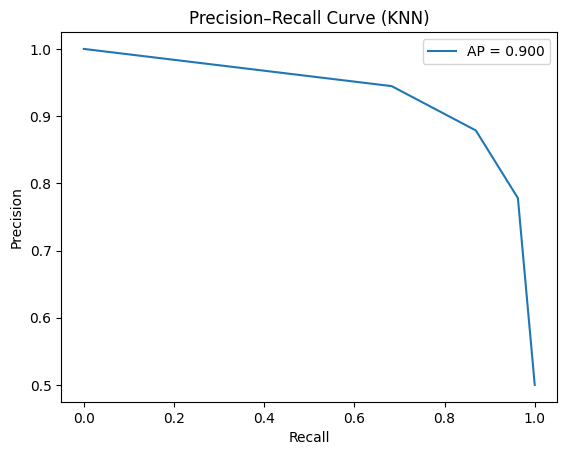

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, _ = precision_recall_curve(y_test, y_proba)
ap = average_precision_score(y_test, y_proba)

plt.figure()
plt.plot(recall, precision, label=f"AP = {ap:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve (KNN)")
plt.legend()
plt.show()


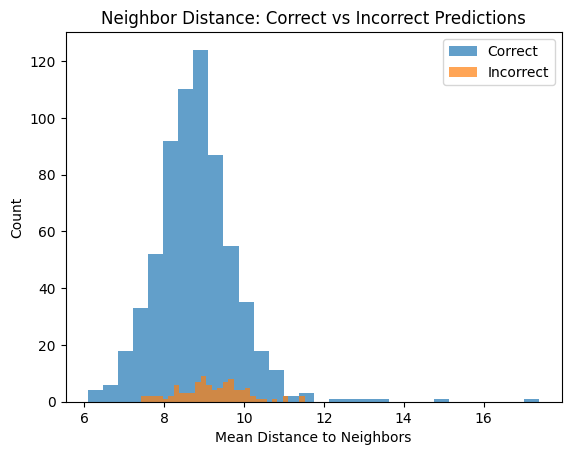

In [ ]:
from sklearn.neighbors import NearestNeighbors

nn = NearestNeighbors(n_neighbors=best_knn.n_neighbors)
nn.fit(X_train_scaled)

distances, _ = nn.kneighbors(X_test_scaled)

mean_dist = distances.mean(axis=1)

correct = (y_pred == y_test)

plt.figure()
plt.hist(mean_dist[correct], bins=30, alpha=0.7, label="Correct")
plt.hist(mean_dist[~correct], bins=30, alpha=0.7, label="Incorrect")
plt.xlabel("Mean Distance to Neighbors")
plt.ylabel("Count")
plt.title("Neighbor Distance: Correct vs Incorrect Predictions")
plt.legend()
plt.show()


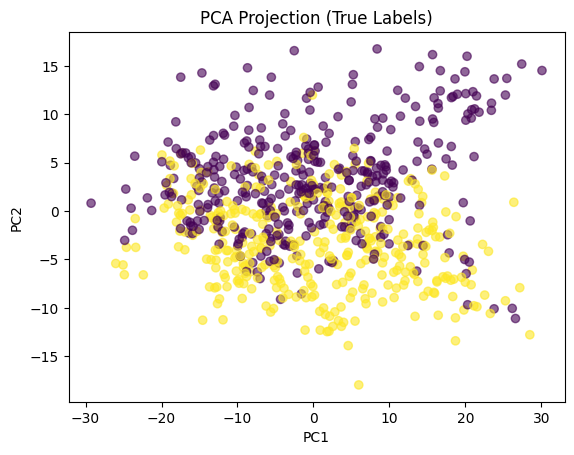

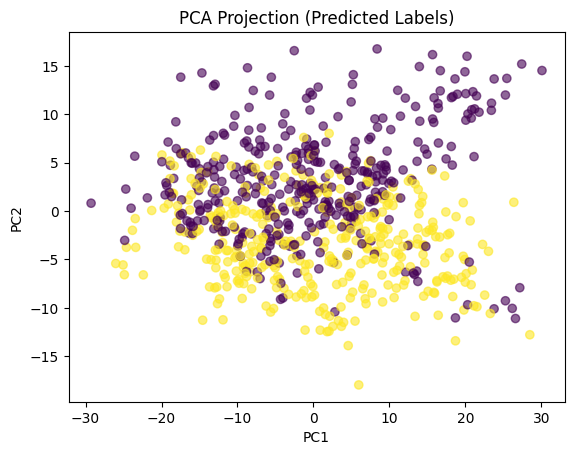

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_test_scaled)

plt.figure()
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_test, alpha=0.6)
plt.title("PCA Projection (True Labels)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

plt.figure()
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred, alpha=0.6)
plt.title("PCA Projection (Predicted Labels)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


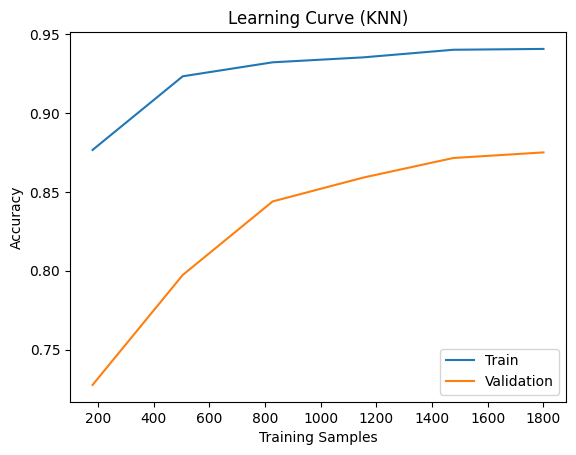

In [ ]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, val_scores = learning_curve(
    best_knn,
    X_train_scaled,
    y_train,
    cv=5,
    scoring="accuracy",
    train_sizes=np.linspace(0.1, 1.0, 6)
)

plt.figure()
plt.plot(train_sizes, train_scores.mean(axis=1), label="Train")
plt.plot(train_sizes, val_scores.mean(axis=1), label="Validation")
plt.xlabel("Training Samples")
plt.ylabel("Accuracy")
plt.title("Learning Curve (KNN)")
plt.legend()
plt.show()
